<a href="https://colab.research.google.com/github/Drovie/Machine_Learning/blob/main/%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Построение логистической регрессии

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import nltk
from nltk import wordpunct_tokenize, WordNetLemmatizer, sent_tokenize, pos_tag
from nltk.corpus import stopwords as sw, wordnet as wn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import string
df = pd.read_excel("/content/sample_data/Выгрузка_9_апреля.xlsx") #Загрузка датасета из файла
df

ModuleNotFoundError: No module named 'keras.preprocessing.text'

In [ ]:
#По требованиям к заданию, необходимо осуществить автоматическую сортировку входящей корреспонденциии
#Для машинного обучения в рамках задания не имеют смысла столбцы с порядковми номерами (потому что они не имеют смысловой ценности), точно так же и столбец "№\nДокумента",
#нет необходимости в столбцах "Дата\регистрации", "Исх. №\Дата", поскольку они выполняют больше служебную функцию сортироваки данных во времени, что напрямую к адресатам не имеет никакого отношения
#Вместе с тем столбец "Примечание" по большей части не имеет внутри себя значений, пригодных для обработки, поэтому, в силу своей недостаточности, для создания модели он не нужен
ddf = df.drop(['№ п/п', '№\nдокумента', 'Дата\nрегистрации', 'Исх. №\nДата', 'Примечание'], axis=1)
ddf

,Адресат,Автор,Краткое\nсодержание
0,Уразов Р.Н.,Антонова С.В. (АО «Интерфакс»),Вх - О возможности использования сетевого изда...
1,Уразов Р.Н.,Картошкин С.А. (Министерство просвещения Росси...,Вх - Об участии в совещании по вопросу доработ...
2,Уразов Р.Н.,Цивилев С.Е. (Администрация Кемеровской области),Вх - О командировании Саликовой К. и Глушко Д....
3,Иванюк Л.А.,Волков Г.А. (Министерство транспорта Российско...,Вх - Об участии в Чемпионате мира по профессио...
4,Уразов Р.Н.,Атанов И.В. (Ставропольский государственный аг...,Вх - Об участии в церемонии открытия Вузовског...
...,...,...,...
4962,Уразов Р.Н.,Медведев Д.А. (Аппарат Правительства Российско...,Протокол заседания Президиума Совета при Прези...
4963,Уразов Р.Н.,Синюгина Т.Ю. (Министерство образования и наук...,О проведении 21.11.2017 заседания организацион...
4964,Уразов Р.Н.,Огородова Л.М. (Министерство образования и нау...,Протокол заседания рабочей группы приоритетног...
4965,Уразов Р.Н.,Огородова Л.М. (Министерство образования и нау...,Протокол заседания рабочей группы приоритетног...


In [ ]:
company_raw = ddf['Автор'].str.split('(') #разделение данных столбца "Автор" на две группы - на самого "Автора" и "Компанию\Отправителя", от лица которой он выступает
author = company_raw
company_raw = [item[1].replace(')', '') for item in company_raw] #приведение данных в столбце "Компания\Отправитель" в корректный виде - форматирование, удаление скобок
author = [item[0] for item in author]


In [ ]:
ddf['Компания\Отправитель'] = company_raw
ddf['Автор'] = author
ddf

,Адресат,Автор,Краткое\nсодержание,Компания\Отправитель
0,Уразов Р.Н.,Антонова С.В.,О возможности использования сетевого издания...,АО «Интерфакс»
1,Уразов Р.Н.,Картошкин С.А.,Об участии в совещании по вопросу доработки ...,Министерство просвещения Российской Федерации
2,Уразов Р.Н.,Цивилев С.Е.,О командировании Саликовой К и Глушко Д для ...,Администрация Кемеровской области
3,Иванюк Л.А.,Волков Г.А.,Об участии в Чемпионате мира по профессионал...,Министерство транспорта Российской Федерации
4,Уразов Р.Н.,Атанов И.В.,Об участии в церемонии открытия узовского че...,Ставропольский государственный аграрный универ...
...,...,...,...,...
4962,Уразов Р.Н.,Медведев Д.А.,Протокол заседания Президиума Совета при Прези...,Аппарат Правительства Российской Федерации
4963,Уразов Р.Н.,Синюгина Т.Ю.,О проведении заседания организационного комит...,Министерство образования и науки РФ. Заместите...
4964,Уразов Р.Н.,Огородова Л.М.,Протокол заседания рабочей группы приоритетног...,Министерство образования и науки Российской Фе...
4965,Уразов Р.Н.,Огородова Л.М.,Протокол заседания рабочей группы приоритетног...,Министерство образования и науки Российской Фе...


In [ ]:
x = ddf['Адресат'].tolist()


KeyError: ignored

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=ed1274c42b20f813ef7a139e01d4e85ad838a8e2f569cc80402c86a7e406f7a4
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(ddf['Краткое\nсодержание']) #Векторизация
X

<4967x5211 sparse matrix of type '<class 'numpy.int64'>'
	with 46959 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(df['Адресат']) #присванивание "идентификатора" для каждого уникального значения столбца "Адресат"

In [ ]:
y

array([143, 143, 143, ..., 143, 143, 143])

In [ ]:
from umap import UMAP

X_embedded_visual = UMAP(n_components = 2, n_neighbors=4, random_state=42, n_jobs=1).fit_transform(X) # для визуализации
X_embedded_visual[:5] # преобразуем наши вектора с длиной 991 элементов, в вектор размером в 20 элементов

/usr/local/lib/python3.10/dist-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


array([[-1.8706485,  4.35841  ],
       [-8.722195 , -1.1869762],
       [-4.8718634,  4.773875 ],
       [-6.5067167, -9.361984 ],
       [-8.068185 , -2.2112124]], dtype=float32)

<Axes: >

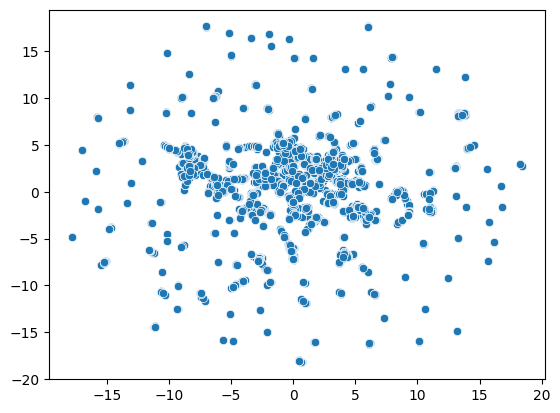

In [ ]:
import seaborn as sns
sns.scatterplot(x=X_embedded_visual[:, 0], y=X_embedded_visual[:, 1])

<Axes: >

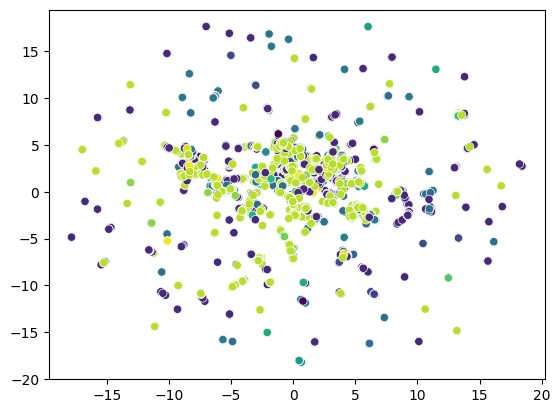

In [ ]:
sns.scatterplot(x=X_embedded_visual[:, 0], y=X_embedded_visual[:, 1], c=y)

По данным графиков, построенных по методологии "Bag of words" нельзя сказать об определённых зависимостях. Использованные в базе данных слова не распределены по группам или явным кластерам, а значит, установить прямую связь, закономерности и принадлежность к категории на данном этапе невозможно. Цвета, соответствующие значениям адресатов не позволяют выделить достаточно чётких взаимосвязей - данные не точны и не достаточны. Необходима дополнительная обработка текста.

In [ ]:
v = TfidfVectorizer()
x1 = v.fit_transform(ddf['Краткое\nсодержание'])
x1

<4967x5211 sparse matrix of type '<class 'numpy.float64'>'
	with 46959 stored elements in Compressed Sparse Row format>

In [ ]:
y1 = LabelEncoder().fit_transform(df['Адресат'])
y1

array([143, 143, 143, ..., 143, 143, 143])

In [ ]:
x1_embedded_visual = UMAP(n_components = 2, n_neighbors=4, random_state=42, n_jobs=1).fit_transform(x1) # для визуализации
x1_embedded_visual[:5] # преобразование вектора размером 4967*5211 элементов в вектор меньшей размерности

array([[13.175946  , -7.4463577 ],
       [ 7.148091  ,  2.3636458 ],
       [ 9.432298  ,  9.907476  ],
       [-8.546696  , 13.833208  ],
       [-0.03732282,  8.940275  ]], dtype=float32)

<Axes: >

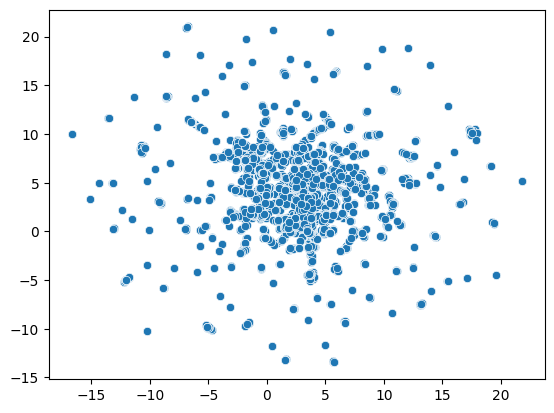

In [ ]:
sns.scatterplot(x=x1_embedded_visual[:, 0], y=x1_embedded_visual[:, 1])

<Axes: >

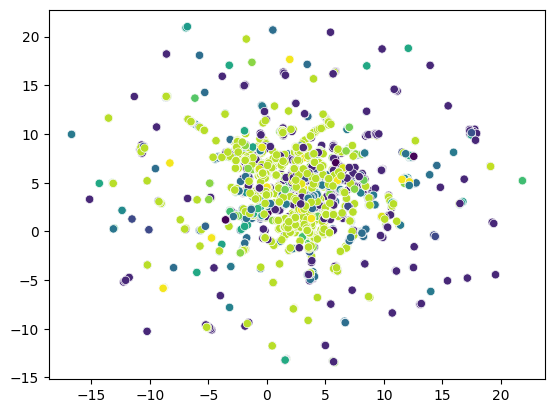

In [ ]:
sns.scatterplot(x=x1_embedded_visual[:, 0], y=x1_embedded_visual[:, 1], c=y1)

По данным графиков, построенных по методологии "TF-IDF" также нельзя сказать об определённых зависимостях. Использованные в базе данных слова не распределены по группам или явным кластерам, а значит, установить прямую связь, закономерности и принадлежность к категории на данном этапе невозможно. Цвета, соответствующие значениям адресатов не позволяют выделить достаточно чётких взаимосвязей - данные не точны и не достаточны. Для изменения точности полученных данных необходима дальнейшая обработка текста.

In [ ]:
#non_alphabet = ddf
#non_alphabet['Краткое\nсодержание'] = non_alphabet['Краткое\nсодержание'].apply(lambda x: re.sub('[,.0-9()""«»/\_№Вх-]', '',x))
#non_alphabet['Компания\Отправитель'] = non_alphabet['Компания\Отправитель'].apply(lambda x: re.sub('[0-9()."",«»></\_№Вх-]', ' ',x))

#non_alphabet = pd.DataFrame([non_alphabet[column].str.lower() for column in non_alphabet])
#non_alphabet.transpose()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Разделяем выборку на тестовую и обучающую

Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
result_logreg = logreg.fit(X_train, y_train)
#logreg.score(X_test,y_test)
logreg.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6770623742454729

Проведено обучение и тестирование подели по алгоритму логистической регрессии. Данные метрики F1 - score = 0.68

Метод опорных векторов

In [ ]:
from sklearn import svm
metodsvm = svm.SVC()
result_svm = metodsvm.fit(X_train, y_train)
metodsvm.score(X_test, y_test)

0.6609657947686117

Проведено обучение и тестирование модели по методу опорных векторов. Показатель F1-score = 0.66